In [23]:
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


HMDA_PATH = 'data/hmda_lar__smith_county__all_years.csv'

# Loading

In [24]:
raw_hmda = pd.read_csv(HMDA_PATH, dtype={
    'census_tract_number': 'str'
})

tract_geos = gpd.read_file('data/tl_2017_48_tract')

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (28,29,30,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Enrichment

In [87]:
enriched_hmda = raw_hmda.copy(deep=True)

enriched_hmda['log_loan_amount_000s'] = np.log(enriched_hmda['loan_amount_000s'])
enriched_hmda['log_applicant_income_000s'] = np.log(enriched_hmda['applicant_income_000s'])

def race_ethnicity(row):
    if row['applicant_ethnicity_name'] == 'Hispanic or Latino':
        return 'Hispanic or Latino'
    elif row['applicant_ethnicity_name'] == 'Not Hispanic or Latino':
        if row['applicant_race_name_1'] == 'White':
            return 'White'
        elif row['applicant_race_name_1'] == 'Black or African American':
            return 'Black or African American'
        elif row['applicant_race_name_1'] == 'Asian':
            return 'Asian'
        else:
            return 'Other or N/A'
    
    return 'Other or N/A'

enriched_hmda['race_ethnicity'] = enriched_hmda.apply(race_ethnicity, axis=1)

def census_tract_number_string(row):
    if str(row['census_tract_number']) == 'nan':
        return None
    
    return str(row['census_tract_number']).replace('.', '').rjust(6, '0')

enriched_hmda['census_tract_number_string'] = enriched_hmda.apply(census_tract_number_string, axis=1)

enriched_hmda['census_tract_number_string'].value_counts()

001904    6638
001401    5528
001903    5159
002009    4638
001908    4565
002007    4263
002008    3989
002200    3722
001402    3420
001802    3155
001905    3024
001000    2998
001700    2764
001803    2573
002100    2561
001907    2479
001906    2475
000800    2455
001500    2402
001801    2385
001601    2380
002006    2378
001101    2275
001602    2119
001901    2010
001403    1984
001404    1915
001200    1777
002102    1663
001102    1552
000100    1484
001603    1350
001604    1284
002004    1235
001300    1100
000900    1049
002003     846
000300     820
002101     804
000201     653
000700     564
000400     440
000500     390
000600     327
000202     290
Name: census_tract_number_string, dtype: int64

# Filtering

In [5]:
filtered_hmda = enriched_hmda.copy(deep=True)

filtered_hmda = filtered_hmda[
    (filtered_hmda['loan_type_name'] == 'Conventional') &
    (filtered_hmda['property_type_name'] == 'One-to-four family dwelling (other than manufactured housing)') &
    (filtered_hmda['owner_occupancy_name'] == 'Owner-occupied as a principal dwelling') &
    (filtered_hmda['loan_purpose_name'] == 'Home purchase') &
    (filtered_hmda['action_taken_name'].isin(['Loan originated', 'Application denied by financial institution'])) &
    (filtered_hmda['loan_amount_000s'] < 90000) &
    (filtered_hmda['applicant_income_000s'] != 9999)
]

# Q: How many loans are approved by race and ethnicity, by year?

In [15]:
def approved(group_column):
    counts = group_column.value_counts()
    
    return counts['Loan originated']

def denied(group_column):
    counts = group_column.value_counts()
    
    return counts['Application denied by financial institution']

def pct_denied(group_column):
    counts = group_column.value_counts()
    
    return counts['Application denied by financial institution'] / sum(counts) * 100

data = filtered_hmda.groupby(['race_ethnicity', 'as_of_year'], as_index=False).agg({
    'state_name': 'count',
    'action_taken_name': [approved, denied, pct_denied],
    'applicant_income_000s': 'mean',
    'loan_amount_000s': 'mean',
})

data = data.rename(index=str, columns={
    'state_name': 'applicant_count'
})

data

race_ethnicity as_of_year applicant_count action_taken_name  \
                                                   count          approved   
0                       Asian       2007              35                29   
1                       Asian       2008              22                21   
2                       Asian       2009              20                17   
3                       Asian       2010              17                14   
4                       Asian       2011              16                12   
5                       Asian       2012              19                14   
6                       Asian       2013              35                30   
7                       Asian       2014              29                22   
8                       Asian       2015              43                37   
9                       Asian       2016              36                32   
10                      Asian       2017              42                39   
11  Black or African American       2007             171               104   
12  Black or African American       2008              51                34   
13  Black or African American       2009              36                22   
14  Black or African American       2010              45                25   
15  Black or African American       2011              21                17   
16  Black or African American       2012              40                17   
17  Black or African American       2013              39                31   
18  Black or African American       2014              47                34   
19  Black or African American       2015              47                30   
20  Black or African American       2016              52                42   
21  Black or African American       2017              63                53   
22         Hispanic or Latino       2007             251               198   
23         Hispanic or Latino       2008             111                87   
24         Hispanic or Latino       2009              87                70   
25         Hispanic or Latino       2010              73                61   
26         Hispanic or Latino       2011              97                79   
27         Hispanic or Latino       2012             108                85   
28         Hispanic or Latino       2013             125               101   
29         Hispanic or Latino       2014             137               105   
30         Hispanic or Latino       2015             142               123   
31         Hispanic or Latino       2016             153               117   
32         Hispanic or Latino       2017             177               146   
33               Other or N/A       2007             272               211   
34               Other or N/A       2008             114                95   
35               Other or N/A       2009              80                68   
36               Other or N/A       2010              54                42   
37               Other or N/A       2011              52                45   
38               Other or N/A       2012              87                71   
39               Other or N/A       2013              76                68   
40               Other or N/A       2014              86                74   
41               Other or N/A       2015              92                73   
42               Other or N/A       2016             115                94   
43               Other or N/A       2017             130               115   
44                      White       2007            2100              1886   
45                      White       2008            1327              1184   
46                      White       2009             882               769   
47                      White       2010             844               749   
48                      White       2011             804               717   
49                      White       2

# Q: How much more likely are white applicants to successfully apply for loans than applicants of color? (2010-2017)

In [40]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def approved(group_column):
    counts = group_column.value_counts()
    
    return counts['Loan originated']

def denied(group_column):
    counts = group_column.value_counts()
    
    return counts['Application denied by financial institution']

def pct_denied(group_column):
    counts = group_column.value_counts()
    
    return counts['Application denied by financial institution'] / sum(counts) * 100

data = filtered_hmda.groupby('race_ethnicity', as_index=False).agg({
    'state_name': 'count',
    'action_taken_name': [approved, denied, pct_denied],
    'applicant_income_000s': 'mean',
    'loan_amount_000s': 'mean',
})

data = data.rename(index=str, columns={
    'state_name': 'applicant_count'
})

data

race_ethnicity applicant_count action_taken_name         \
                                       count          approved denied   
0                      Asian             314               267     47   
1  Black or African American             612               409    203   
2         Hispanic or Latino            1461              1172    289   
3               Other or N/A            1158               956    202   
4                      White           13201             11826   1375   

             applicant_income_000s loan_amount_000s  
  pct_denied                  mean             mean  
0  14.968153            128.319355       205.254777  
1  33.169935             79.413907       149.062092  
2  19.780972             65.261411       111.692676  
3  17.443869            104.904509       175.129534  
4  10.415878            117.180769       184.154685

# Q: What tracts have the highest number of loan for each race and ethnicity? (2010-2017)

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


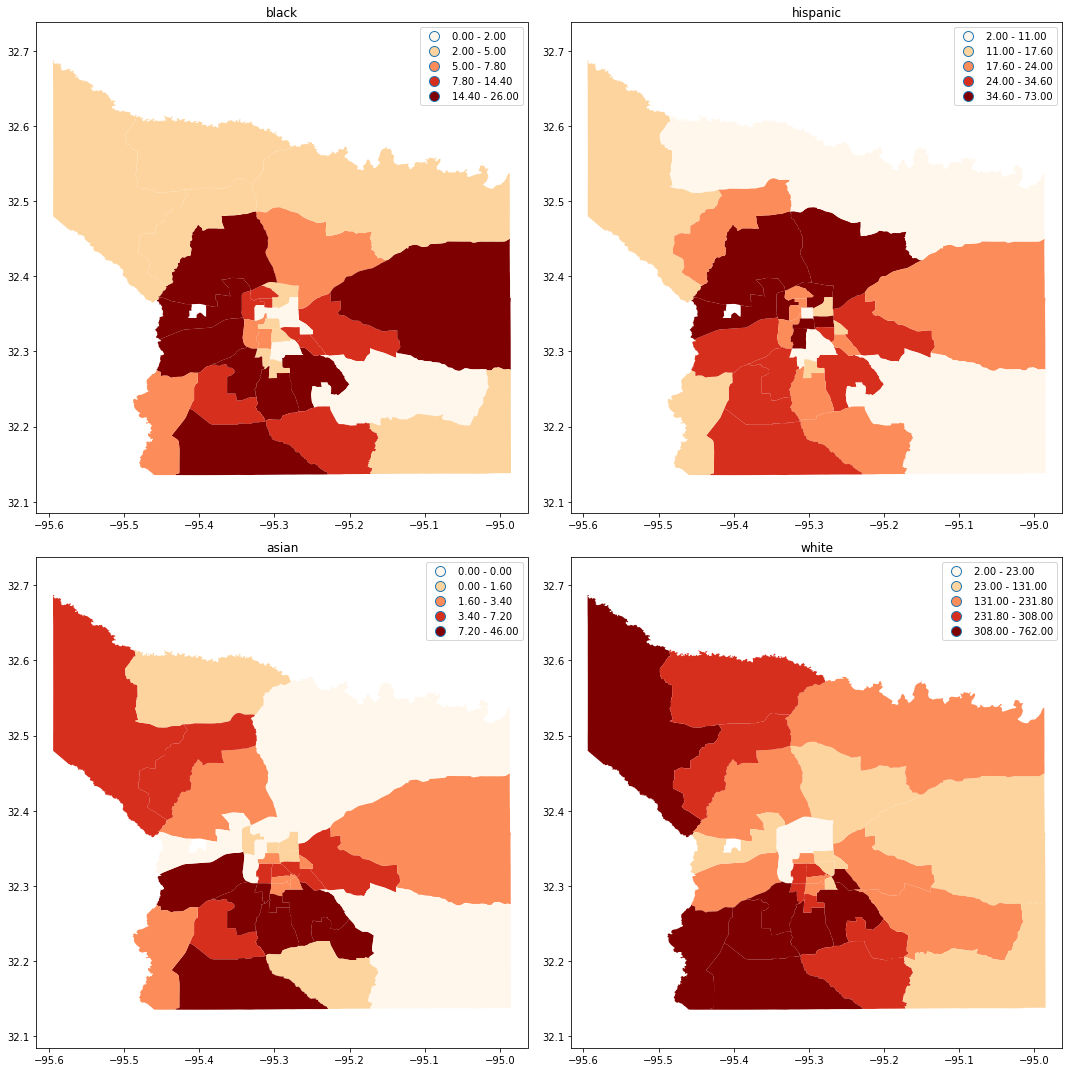

In [84]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def black(group_column):
    return group_column.value_counts().get('Black or African American', 0)

def hispanic(group_column):
    return group_column.value_counts().get('Hispanic or Latino', 0)

def asian(group_column):
    return group_column.value_counts().get('Asian', 0)

def white(group_column):
    return group_column.value_counts().get('White', 0)

def other(group_column):
    return group_column.value_counts().get('Other or N/A', 0)

data = data.groupby('census_tract_number_string', as_index=False).agg({
    'race_ethnicity': ['count', black, hispanic, asian, white]
})

data = tract_geos.merge(data, left_on='TRACTCE', right_on='census_tract_number_string')

plt.figure(figsize=(15, 15))

for i, group in enumerate(['black', 'hispanic', 'asian', 'white']):
    ax = plt.subplot(2, 2, i + 1)
    data.plot(column=('race_ethnicity', group), ax=ax, cmap='OrRd', scheme='Quantiles', legend=True)
    ax.set_title(group)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

# Q: What tracts have the highest proportion of loans for each race and ethnicity? (2010-2017)

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


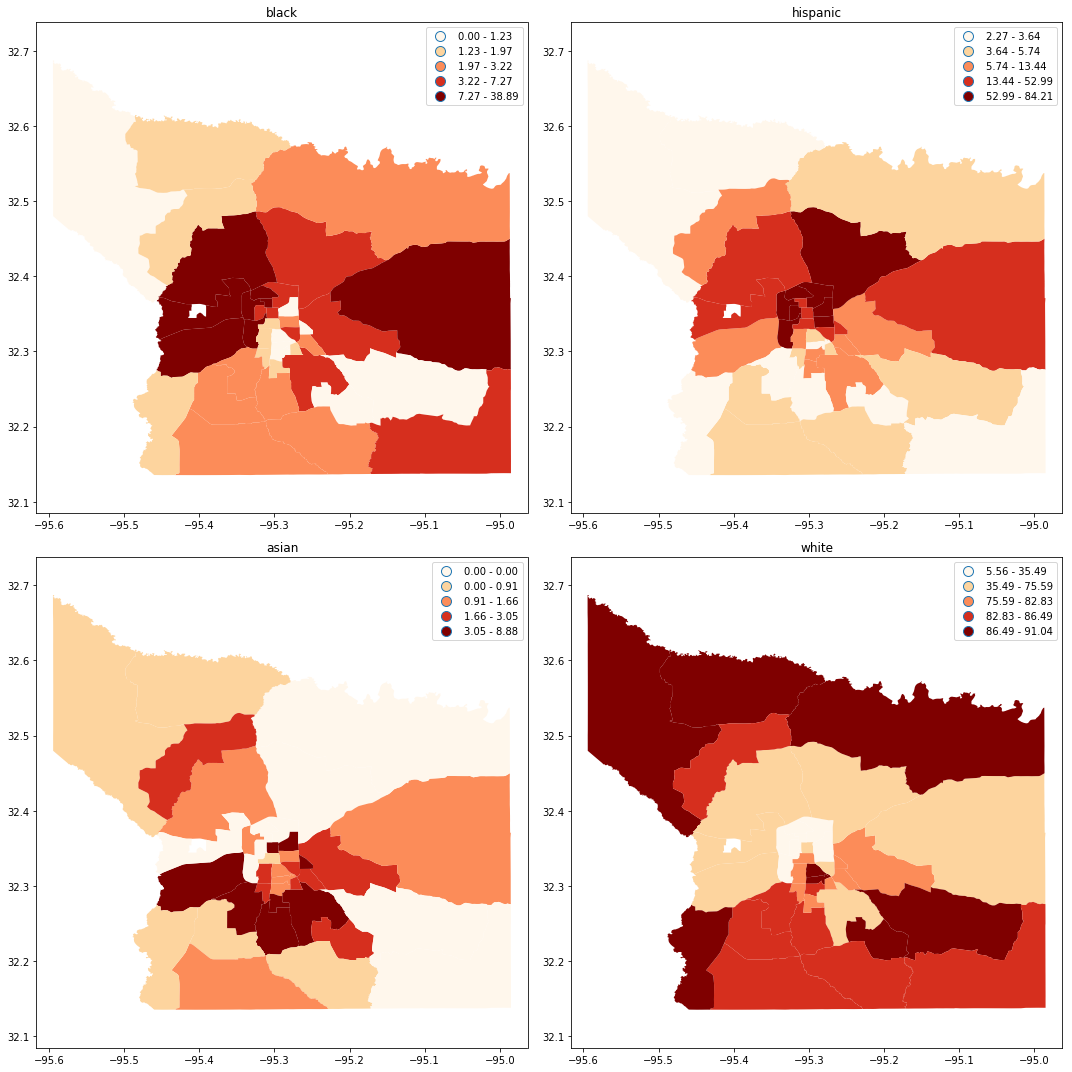

In [83]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def black(group_column):
    return group_column.value_counts(normalize=True).get('Black or African American', 0) * 100

def hispanic(group_column):
    return group_column.value_counts(normalize=True).get('Hispanic or Latino', 0) * 100

def asian(group_column):
    return group_column.value_counts(normalize=True).get('Asian', 0) * 100

def white(group_column):
    return group_column.value_counts(normalize=True).get('White', 0) * 100

def other(group_column):
    return group_column.value_counts(normalize=True).get('Other or N/A', 0) * 100

data = data.groupby('census_tract_number_string', as_index=False).agg({
    'race_ethnicity': [black, hispanic, asian, white]
})

data = tract_geos.merge(data, left_on='TRACTCE', right_on='census_tract_number_string')

plt.figure(figsize=(15, 15))

for i, group in enumerate(['black', 'hispanic', 'asian', 'white']):
    ax = plt.subplot(2, 2, i + 1)
    data.plot(column=('race_ethnicity', group), ax=ax, cmap='OrRd', scheme='Quantiles', legend=True)
    ax.set_title(group)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

# Q: How are the share of black and Hispanic loans changing over time? (2010-2017)

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


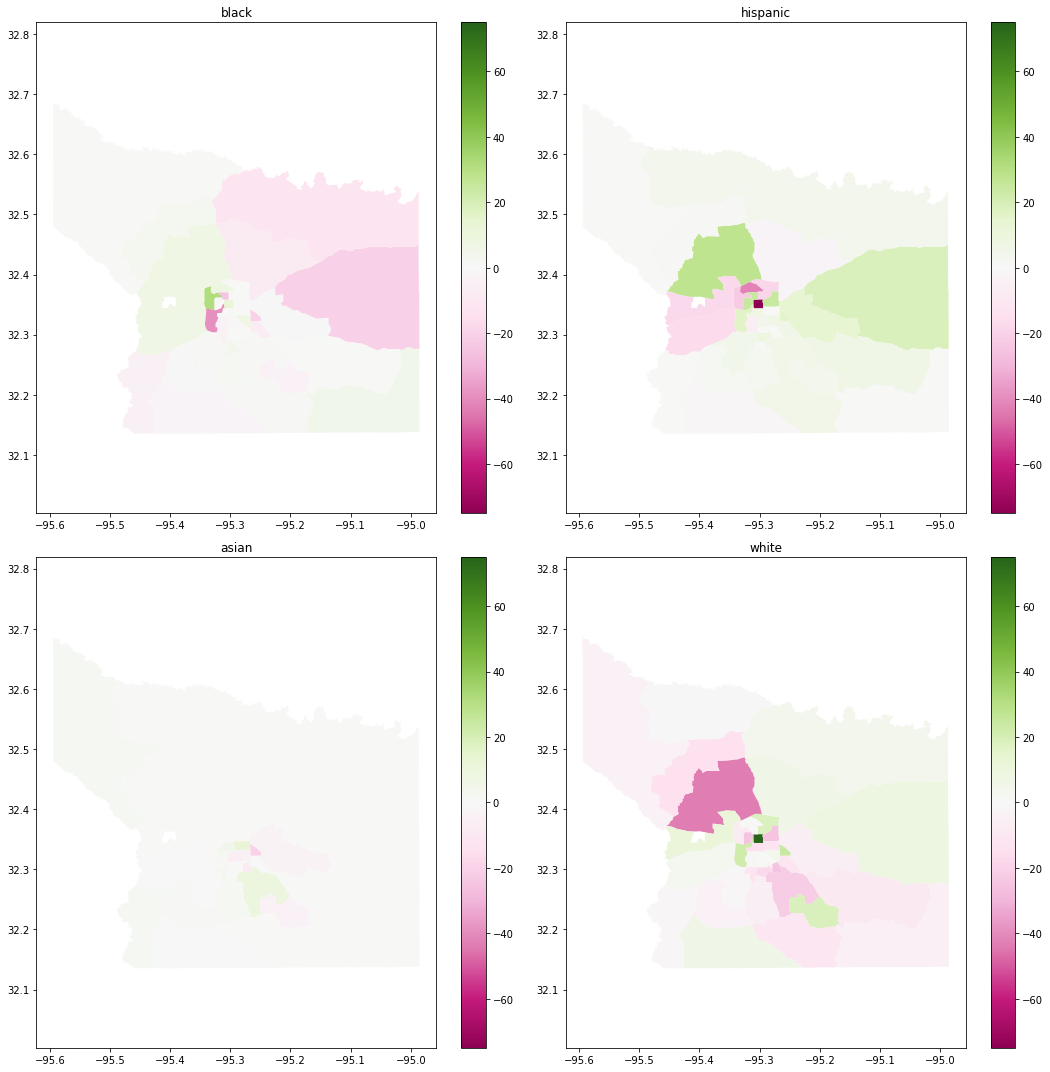

In [93]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def black(group_column):
    return group_column.value_counts(normalize=True).get('Black or African American', 0) * 100

def hispanic(group_column):
    return group_column.value_counts(normalize=True).get('Hispanic or Latino', 0) * 100

def asian(group_column):
    return group_column.value_counts(normalize=True).get('Asian', 0) * 100

def white(group_column):
    return group_column.value_counts(normalize=True).get('White', 0) * 100

data = data.groupby(['census_tract_number_string', 'as_of_year'], as_index=False).agg({
    'race_ethnicity': ['count', black, hispanic, asian, white]
})

def change(group_column):
    return group_column.iat[-1] - group_column.iat[0]

data = data.groupby('census_tract_number_string', as_index=False).agg({
    ('race_ethnicity', 'black'): change,
    ('race_ethnicity', 'hispanic'): change,
    ('race_ethnicity', 'asian'): change,
    ('race_ethnicity', 'white'): change
})

data = tract_geos.merge(data, left_on='TRACTCE', right_on='census_tract_number_string')

plt.figure(figsize=(15, 15))

for i, group in enumerate(['black', 'hispanic', 'asian', 'white']):
    ax = plt.subplot(2, 2, i + 1)
    data.plot(column=('race_ethnicity', group), ax=ax, cmap='PiYG', legend=True, vmin=-75, vmax=75)
    ax.set_title(group)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

In [ ]:
# Summarize by tract
tract_hmda = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def majority(group_column):
    counts = group_column.value_counts(normalize=True)
    
    if counts['White'] > 0.5:
        return 'White'
    
    return 'Minority'

tract_hmda = tract_hmda.groupby('census_tract_number_string', as_index=False).agg({
    'state_name': 'count',
    'applicant_income_000s': 'mean',
    'loan_amount_000s': 'mean',
    'race_ethnicity': majority
})

tract_hmda.head()

In [ ]:


tracts_merged = tract_geos.merge(tract_hmda, left_on='TRACTCE', right_on='census_tract_number_string')

In [ ]:
# Plot by income
tracts_merged.plot(column='applicant_income_000s', cmap='OrRd', scheme='Quantiles', legend=True, figsize=(10, 10))

In [ ]:
# Plot by loan amount
tracts_merged.plot(column='loan_amount_000s', cmap='OrRd', scheme='Quantiles', legend=True, figsize=(10, 10))